# Cell 0: Notebook Header & Documentation
# Description: Provides context and instructions for this biological analysis notebook.
#              This notebook performs GO enrichment analysis on the STATIC "Red Region"
#              identified from the H+P Reference run (`ablation_01`).

## Notebook Title: Ablation Study - Static Red Region Biological Analysis

### Purpose and Context

*   **Goal:** To perform biological relevance analysis on the **static** "Red Region" nodes identified at the *final step* of the baseline H+P simulation run (`ablation_01`). This notebook specifically analyzes the biological relevance of patterns defined by a simple static threshold.
*   **Contribution:** Loads the identified "Red Region" node IDs, maps them to gene symbols using the STRING API, performs GO Biological Process enrichment analysis, and visualizes the top enriched terms.
*   **Inputs:**
    *   Requires the baseline configuration file (`baseline_config.json`) saved by `ablation_00`.
    *   Requires the file containing STRING IDs of nodes in the **static Red Region** identified by the H+P Reference run (`simulation_results/aifm1_red_ids.txt`) generated by `ablation_01`.
*   **Outputs:**
    *   A dedicated biological analysis output folder (`biological_analysis_results/Analysis_aifm1_red_ids`).
    *   Saved files related to the analysis:
        *   `analysis_config.json` (configuration used for this analysis).
        *   `string_id_to_gene_symbol_map_cache.pkl` (cache of STRING ID to Gene Symbol mappings).
        *   `red_region_mapped_symbols.txt` (list of mapped gene symbols).
        *   `red_region_enrichment_results.csv` (full table of enrichment results).
        *   `red_region_enrichment_plot.png` (bar plot of top enriched terms).
    *   Inline markdown summary of the analysis findings.

### How to Run

*   **Prerequisites:** Ensure `ablation_00_Setup_and_Definitions.ipynb` has been run successfully. Ensure `ablation_01_Run_HP_Reference_and_Generate_IDs.ipynb` has been run successfully to generate the `simulation_results/aifm1_red_ids.txt` file. Ensure the Canonical Helper Functions for biological analysis are defined in Cell 2 of THIS notebook.
*   **Configuration:** No user edits are required; Cell 1 loads the baseline config and defines specific analysis parameters.
*   **Execution:** Run all cells sequentially from top to bottom (Cell 0 through Cell 7).
*   **Expected Runtime:** Variable, depends on the size of the "Red Region" list and the responsiveness of the STRING API and Enrichr server. May take several minutes for large lists.

### Expected Results & Analysis (within this notebook)

*   This notebook attempts to load the `aifm1_red_ids.txt` file. If successful, it will proceed to map the IDs and perform enrichment.
*   Successful execution results in:
    *   Messages confirming loading of Red Region IDs.
    *   Progress bars and messages detailing the STRING API mapping process.
    *   Output listing the top enriched GO Biological Process terms (if any are significant).
    *   Saved analysis files in the dedicated output folder.
    *   Display of the enrichment bar plot (if generated).
    *   A final markdown summary interpreting the biological relevance based on the enrichment findings for this *static* region.
*   If the `aifm1_red_ids.txt` file is missing or empty (because the H+P reference run did not produce a Red Region above the threshold), subsequent analysis steps will be skipped with informative messages.

In [1]:
# Cell 1: Configuration (Biological Analysis)
# Description: Loads baseline configuration and defines specific analysis parameters.
#              MODIFIED: Ensures TARGET_NODE_ID and TARGET_NODE_NAME are set as globals.

import os
import json
import time
import traceback
import warnings
import numpy as np # Needed for np.nan checks later

print(f"\n--- Cell 1: Configuration (Biological Analysis) ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# --- Load Baseline Configuration ---
config_load_error = False
baseline_config = {}
setup_output_dir_load = os.path.join("simulation_results", "Ablation_Setup_Files")

try:
    config_path_load = os.path.join(setup_output_dir_load, "baseline_config.json")
    if not os.path.exists(config_path_load): raise FileNotFoundError(f"Baseline config file not found: {config_path_load}. Run ablation_00.")
    with open(config_path_load, 'r') as f: baseline_config = json.load(f)
    print(f"  ✅ Loaded baseline configuration from: {config_path_load}")

    # Extract needed base parameters into local variables for this notebook
    OUTPUT_DIR_SIMULATIONS = baseline_config.get('OUTPUT_DIR', "simulation_results") # Base dir for sim outputs
    ANALYSIS_DIR_BASE = baseline_config.get('ANALYSIS_DIR', "biological_analysis_results") # Base dir for THIS notebook's output

    # --- Extract TARGET_NODE_ID and TARGET_NODE_NAME and set as GLOBALS ---
    TARGET_NODE_ID = baseline_config.get('TARGET_NODE_ID') # AIFM1 ID from setup
    TARGET_NODE_NAME = baseline_config.get('TARGET_NODE_NAME', 'TargetProtein') # Get name if exists, default if not
    globals()['TARGET_NODE_ID'] = TARGET_NODE_ID # Set as global
    globals()['TARGET_NODE_NAME'] = TARGET_NODE_NAME # Set as global
    print(f"  Target Node ID loaded and set globally: {TARGET_NODE_ID} ({TARGET_NODE_NAME})")
    # --- END Extract and Set GLOBALS ---


except FileNotFoundError as e: print(f"❌ ERROR: {e}"); config_load_error = True
except Exception as e: print(f"❌ Error loading config data: {e}"); traceback.print_exc(limit=1); config_load_error = True


if not config_load_error:
    # --- Analysis Parameters ---
    # Define the path to the input file containing the Red Region IDs from ablation_01
    RED_REGION_IDS_INPUT_FILE = os.path.join(OUTPUT_DIR_SIMULATIONS, "aifm1_red_ids.txt")
    print(f"🧬 Analyzing Red Region IDs from file: {RED_REGION_IDS_INPUT_FILE}")

    # Red Region Threshold (This is the threshold used *by ablation_01* to generate the file)
    # We define it here for reference, but it's not used for filtering in this notebook.
    # Attempt to get this from the summary of the ablation_01 run if possible, otherwise default
    a01_summary_path = os.path.join(OUTPUT_DIR_SIMULATIONS, f"{baseline_config.get('EXPERIMENT_NAME', 'string_ca_subgraph_AIFM1_CORRECTED')}_LinearHarmonicPheromone_REF", "experiment_summary.json")
    RED_REGION_THRESHOLD_USED_BY_01 = 0.5 # Default
    try:
        if os.path.exists(a01_summary_path):
            with open(a01_summary_path, 'r') as f: a01_summary = json.load(f)
            # Check if threshold value was saved in the summary (unlikely in current structure, but maybe future)
            RED_REGION_THRESHOLD_USED_BY_01_in_summary = a01_summary.get('red_region_threshold_used', None) # Assuming a key name
            if RED_REGION_THRESHOLD_USED_BY_01_in_summary is not None:
                 RED_REGION_THRESHOLD_USED_BY_01 = RED_REGION_THRESHOLD_USED_BY_01_in_summary
                 print(f"   (Red Region Threshold used by ablation_01 found in summary: Act-Inh > {RED_REGION_THRESHOLD_USED_BY_01})")
            else:
                 print(f"   (Using default Red Region Threshold for reference: Act-Inh > {RED_REGION_THRESHOLD_USED_BY_01})")
        else:
             print(f"   (Summary file for ablation_01 not found at {a01_summary_path}. Using default Red Region Threshold for reference: Act-Inh > {RED_REGION_THRESHOLD_USED_BY_01})")

    except Exception as e_a01_summary:
        print(f"   ⚠️ Warning: Could not load or parse ablation_01 summary for threshold reference: {e_a01_summary}")
        print(f"   (Using default Red Region Threshold for reference: Act-Inh > {RED_REGION_THRESHOLD_USED_BY_01})")


    # --- ID Mapping & Enrichment Parameters (Using values or defaults) ---
    SPECIES_ID = "9606" # Human taxonomy ID
    STRING_API_URL = "https://string-db.org/api"
    STRING_MAPPING_ENDPOINT = "/tsv/get_string_ids"
    BATCH_SIZE = 100 # Keep reasonable for API stability
    MAX_RETRIES = 5 # Increased retries
    RETRY_DELAY = 7 # Increased delay
    # Using the latest GO library name or falling back
    GO_ENRICHMENT_LIBRARY = baseline_config.get('GO_LIBRARY', 'GO_Biological_Process_2023') # Use GO_ENRICHMENT_LIBRARY
    # Use GO_ENRICHMENT_LIBRARY as the global name as well for consistency
    globals()['GO_ENRICHMENT_LIBRARY'] = GO_ENRICHMENT_LIBRARY # Set as global


    TOP_N_ENRICHMENT_TERMS = 15 # How many top GO terms to display/plot
    globals()['TOP_N_ENRICHMENT_TERMS'] = TOP_N_ENRICHMENT_TERMS # Set as global
    print(f"   Using GO Enrichment Library: {GO_ENRICHMENT_LIBRARY}")
    print(f"   Displaying top {TOP_N_ENRICHMENT_TERMS} enrichment terms.")

    # --- Experiment-specific Output Subdirectory ---
    # Create a subdirectory within the analysis base dir for this specific analysis
    # Using the name of the input file (without extension) to make the folder name specific
    input_filename_base = os.path.basename(RED_REGION_IDS_INPUT_FILE).split('.')[0] # e.g., 'aifm1_red_ids'
    OUTPUT_DIR_ANALYSIS = os.path.join(ANALYSIS_DIR_BASE, f"Analysis_{input_filename_base}")
    os.makedirs(ANALYSIS_DIR_BASE, exist_ok=True) # Ensure base analysis dir exists
    os.makedirs(OUTPUT_DIR_ANALYSIS, exist_ok=True) # Ensure specific analysis dir exists
    globals()['OUTPUT_DIR_ANALYSIS'] = OUTPUT_DIR_ANALYSIS # Set as global
    print(f"Analysis outputs will be saved in: {os.path.join(os.getcwd(), OUTPUT_DIR_ANALYSIS)}") # Show full analysis output path

    # --- Save Analysis Config ---
    analysis_config_save_path = os.path.join(OUTPUT_DIR_ANALYSIS, "analysis_config.json")
    try:
        # Collect relevant local variables for saving
        analysis_config_dict = {
             'RED_REGION_IDS_INPUT_FILE': RED_REGION_IDS_INPUT_FILE,
             'RED_REGION_THRESHOLD_USED_BY_01': RED_REGION_THRESHOLD_USED_BY_01,
             'SPECIES_ID': SPECIES_ID,
             'STRING_API_URL': STRING_API_URL,
             'STRING_MAPPING_ENDPOINT': STRING_MAPPING_ENDPOINT,
             'BATCH_SIZE': BATCH_SIZE,
             'MAX_RETRIES': MAX_RETRIES,
             'RETRY_DELAY': RETRY_DELAY,
             'GO_ENRICHMENT_LIBRARY': GO_ENRICHMENT_LIBRARY, # Use the variable name
             'TOP_N_ENRICHMENT_TERMS': TOP_N_ENRICHMENT_TERMS, # Use the variable name
             'ANALYSIS_DIR_BASE': ANALYSIS_DIR_BASE,
             'OUTPUT_DIR_ANALYSIS': OUTPUT_DIR_ANALYSIS, # Use the variable name
             'TARGET_NODE_ID': TARGET_NODE_ID, # Use the variable name
             'TARGET_NODE_NAME': TARGET_NODE_NAME # Use the variable name
             # Add any other relevant config variables
        }
        with open(analysis_config_save_path, 'w') as f:
            json.dump(analysis_config_dict, f, indent=4, default=str) # Use default=str for numpy types
        print(f"   ✅ Saved analysis configuration to {analysis_config_save_path}")
    except Exception as e: print(f"   ⚠️ Warning: Could not save analysis configuration: {e}")

else:
     print("\n❌ Configuration loading failed. Analysis cannot proceed.")


print("\nCell 1: Configuration complete.")


--- Cell 1: Configuration (Biological Analysis) (2025-04-28 21:16:55) ---
  ✅ Loaded baseline configuration from: simulation_results/Ablation_Setup_Files/baseline_config.json
  Target Node ID loaded and set globally: 9606.ENSP00000287295 (TargetProtein)
🧬 Analyzing Red Region IDs from file: simulation_results/aifm1_red_ids.txt
   (Using default Red Region Threshold for reference: Act-Inh > 0.5)
   Using GO Enrichment Library: GO_Biological_Process_2023
   Displaying top 15 enrichment terms.
Analysis outputs will be saved in: /home/irbsurfer/Projects/Novyte/Emergenics/production/emergenics/1_NetworkIStheComputation/ablation_study/biological_analysis_results/Analysis_aifm1_red_ids
   ✅ Saved analysis configuration to biological_analysis_results/Analysis_aifm1_red_ids/analysis_config.json

Cell 1: Configuration complete.


In [2]:
# Cell 2: Canonical Helper Functions (Biological Analysis)
# Description: Defines ALL necessary helper functions for loading IDs, mapping to
#              gene symbols via STRING API, running GSEAPY enrichment, and plotting
#              enrichment results. These functions are self-contained within this notebook.
#              MODIFIED: Ensure functions use GLOBALS for config parameters.
#              MODIFIED: Fixed SyntaxError in map_string_ids_to_gene_symbols_api.
#              MODIFIED: Fixed NameError in map_string_ids_to_gene_symbols_api by using the correct variable name.

import pandas as pd
import requests
import time
import io
from tqdm.notebook import tqdm # Use notebook version for progress bars
import os
import warnings
import pickle
import traceback
import numpy as np # For np.nan

# Ensure gseapy is available (checked in Cell 0)
try:
    import gseapy as gp # Rename to gp for consistency
except ImportError:
    gp = None # Set to None to allow checks later

print(f"\n--- Cell 2: Defining Canonical Biological Analysis Helper Functions ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# --- Helper Function: Load STRING IDs from File ---
def load_string_ids_from_txt(filename):
    """Loads STRING IDs directly from a text file (one ID per line)."""
    string_ids = []
    try:
        with open(filename, 'r') as f:
            string_ids = [line.strip() for line in f if line.strip()]
        print(f"  📄 Loaded {len(string_ids)} STRING IDs from '{os.path.basename(filename)}'")
        if not string_ids: warnings.warn(f"Loaded list from '{filename}' is empty.")
        return string_ids
    except FileNotFoundError: print(f"  ❌ Error: File not found at {filename}"); return []
    except Exception as e: print(f"  ❌ Error loading data from {filename}: {e}"); return []

# --- Helper Function: Map STRING IDs to Gene Symbols via API with Caching ---
# MODIFIED: Use GLOBALS for config parameters (SPECIES_ID, API_URL, etc.)
# MODIFIED: Fixed SyntaxError in the error handling block.
# MODIFIED: Fixed NameError in map_string_ids_to_gene_symbols_api by using the correct variable name.
def map_string_ids_to_gene_symbols_api(string_ids, description="IDs"):
    """Maps STRING IDs (e.g., 9606.ENSP...) to Gene Symbols using the STRING API with caching."""
    # Access globals for configuration
    species_id = globals().get('SPECIES_ID', '9606')
    api_url = globals().get('STRING_API_URL', 'https://string-db.org/api')
    mapping_endpoint = globals().get('STRING_MAPPING_ENDPOINT', '/tsv/get_string_ids')
    batch_size = globals().get('BATCH_SIZE', 100)
    max_retries = globals().get('MAX_RETRIES', 3)
    retry_delay = globals().get('RETRY_DELAY', 5)
    output_dir_analysis = globals().get('OUTPUT_DIR_ANALYSIS', '.') # Use global output dir

    if not string_ids: print(f"⚠️ No input STRING IDs provided for {description}. Skipping mapping."); return []
    print(f"Mapping {len(string_ids)} {description} IDs...")

    # --- Caching Logic ---
    mapping_cache_file = os.path.join(output_dir_analysis, 'string_id_to_gene_symbol_map_cache.pkl')
    cached_map = {}
    if os.path.exists(mapping_cache_file):
        try:
             with open(mapping_cache_file, 'rb') as f_cache: cached_map = pickle.load(f_cache)
             if not isinstance(cached_map, dict): cached_map = {}
             else: print(f"  ℹ️ Loaded {len(cached_map)} mappings from cache: {mapping_cache_file}")
        except Exception as e_cache: print(f"  ⚠️ Warning: Could not load mapping cache: {e_cache}. Will rebuild.")

    # --- Identify IDs needing API call ---
    ids_needing_map = sorted(list(set(string_ids) - set(cached_map.keys())))
    mapped_symbols_dict = cached_map.copy() # Start with cache. THIS IS THE CORRECT VARIABLE NAME.

    if ids_needing_map:
        print(f"  🌐 Mapping {len(ids_needing_map)} IDs via STRING API...")
        identifiers_to_map = [sid for sid in ids_needing_map if isinstance(sid, str) and sid.startswith(str(species_id) + '.')]
        if not identifiers_to_map: print("    No valid STRING IDs (starting with species ID) found for mapping via API.");
        else:
            api_map_url = f"{api_url}{mapping_endpoint}"; num_batches = (len(identifiers_to_map) + batch_size - 1)//batch_size;
            use_tqdm = num_batches > 1;
            batch_iterator = tqdm(range(num_batches), desc=f"API Mapping ({description})", leave=False) if use_tqdm else range(num_batches);
            api_errors = 0;
            for i in batch_iterator:
                 batch = identifiers_to_map[i*batch_size:(i+1)*batch_size];
                 payload = {'identifiers': "\r".join(batch), 'species': species_id, 'limit': 1, 'echo_query': 1, 'caller_identity': 'NetworkAutomatonSim/1.0'};
                 retries = 0; success = False; response = None;
                 while retries < max_retries and not success:
                      try:
                           response = requests.post(api_map_url, data=payload, timeout=60);
                           response.raise_for_status();
                           content_type = response.headers.get('Content-Type','');
                           if 'text/tab-separated-values' in content_type:
                                text = response.text;
                                if text and text.strip():
                                     mapping_df = pd.read_csv(io.StringIO(text), sep='\t')
                                     if 'preferredName' in mapping_df.columns and 'queryItem' in mapping_df.columns:
                                          for qid, name in zip(mapping_df['queryItem'], mapping_df['preferredName']):
                                               if pd.notna(name) and name: mapped_symbols_dict[qid] = str(name)
                                     else: warnings.warn(f"API response missing expected columns ('preferredName', 'queryItem') in batch {i+1}."); api_errors += 1; break
                                success = True;
                           else: warnings.warn(f"Unexpected API format batch {i+1}: {content_type}. Retrying..."); retries += 1; time.sleep(retry_delay*(1+retries));
                      except requests.exceptions.Timeout:
                           retries += 1;
                           print(f"\n   Timeout on API call (Batch {i+1}, Retry {retries}/{max_retries}). Sleeping...")
                           time.sleep(retry_delay * (1 + retries));
                      except requests.exceptions.RequestException as e:
                           retries += 1;
                           print(f"   API Request Error (Batch {i+1}, Retry {retries}/{max_retries}): {e}. Sleeping...")
                           time.sleep(retry_delay * (1 + retries));
                      except pd.errors.EmptyDataError: # Catch error if read_csv gets empty data
                           success = True; # Mark as success, no need to retry.
                      except Exception as e:
                           retries += 1;
                           print(f"   Unexpected Error Processing API Response (Batch {i+1}, Retry {retries}/{max_retries}): {e}")
                           traceback.print_exc(limit=1)
                           time.sleep(retry_delay * (1 + retries));

                      # Check if max retries reached inside the loop
                      if retries >= max_retries and not success:
                           print(f"   ❌ API call failed for Batch {i+1} after {retries} retries.")
                           api_errors += 1
            # End For loop for batches

            # Corrected syntax for adding qid to mapped_symbols_dict in the failure case
            if api_errors > 0:
                for i in range(num_batches):
                     batch = identifiers_to_map[i*batch_size:(i+1)*batch_size]
                     for qid in batch:
                          if qid not in mapped_symbols_dict: # Use mapped_symbols_dict
                               mapped_symbols_dict[qid] = qid # Keep original ID if failed
            # END Corrected syntax

            # Save updated cache
            try:
                with open(mapping_cache_file, 'wb') as f_cache: pickle.dump(mapped_symbols_dict, f_cache) # Use mapped_symbols_dict
                print(f"  ✅ Updated mapping cache saved ({len(mapped_symbols_dict)} total mappings).") # Use mapped_symbols_dict
            except Exception as e_save_cache: print(f"  ⚠️ Error saving updated mapping cache: {e_save_cache}")
    else: print("  All required IDs found in cache.");

    # Generate final list of gene symbols from the *original* input string_ids
    mapped_symbols_list = []
    unmapped_count = 0
    for sid in string_ids:
        mapped_val = mapped_symbols_dict.get(sid, sid) # Use mapped_symbols_dict
        if isinstance(mapped_val, str) and not ('.' in mapped_val and mapped_val.split('.')[0] == str(species_id)): # Check if it looks like unprocessed STRING ID
             mapped_symbols_list.append(mapped_val)
        else: unmapped_count += 1
    unique_gene_symbols = sorted(list(set(mapped_symbols_list)))
    print(f"\n✅ Mapping complete. Found {len(unique_gene_symbols)} unique Gene Symbols for {description}.")
    if unmapped_count > 0: print(f"   ({unmapped_count} input IDs remain unmapped or were invalid).")
    if len(string_ids) > 0:
         mapping_yield = len(unique_gene_symbols) / len(string_ids)
         if mapping_yield < 0.5 and len(string_ids) > 10: warnings.warn(f"Mapping yield for {description} seems low ({mapping_yield:.1%}).")
         elif len(unique_gene_symbols) == 0 and len(string_ids) > 0: warnings.warn(f"🚨 Mapping for {description} resulted in ZERO gene symbols.")
    return unique_gene_symbols

# --- Helper Function: Run Enrichment Analysis ---
# MODIFIED: Use GLOBALS for gene_sets and top_n defaults.
def run_enrichment_simple(gene_list, description):
     """Runs gseapy enrichment analysis."""
     # Access globals for configuration
     gene_sets = globals().get('GO_ENRICHMENT_LIBRARY', 'GO_Biological_Process_2023')
     top_n = globals().get('TOP_N_ENRICHMENT_TERMS', 15)

     if gp is None: print("❌ Cannot run enrichment: gseapy not available."); return None
     if not isinstance(gene_list, list) or not all(isinstance(g, str) for g in gene_list):
         print(f"⚠️ Skip enrichment: Input gene_list is not a list of strings.")
         return None
     cleaned_gene_list = [g for g in gene_list if g]
     if not cleaned_gene_list or len(cleaned_gene_list) < 3:
         print(f"⚠️ Skip enrichment '{description}': Needs >= 3 non-empty genes (found {len(cleaned_gene_list)}).");
         return pd.DataFrame()

     print(f"--- 📊 Performing Enrichment: {description} ({len(cleaned_gene_list)} genes) using '{gene_sets}' ---")
     try:
          libs = gp.get_library_name(organism='Human')
          valid_libs = [gene_sets] if gene_sets in libs else [] # Only use the specified library if valid
          if not valid_libs:
              print(f"❌ Invalid or unavailable gene_set: '{gene_sets}'. Available examples: {libs[:5]}")
              return pd.DataFrame()

          enr = gp.enrichr(gene_list=cleaned_gene_list, gene_sets=valid_libs, organism='Human', outdir=None, cutoff=0.05) # Use gp alias

          if enr is None or not hasattr(enr, 'results') or enr.results.empty:
               print(f"ℹ️ No significant terms found for '{description}' using library: '{gene_sets}'.");
               return pd.DataFrame()

          results_df = enr.results.sort_values('Adjusted P-value').reset_index(drop=True)
          print(f"🧬 Top {min(top_n, len(results_df))} Enriched Terms ('{gene_sets}'):")
          display_df=results_df[['Term', 'Adjusted P-value', 'Overlap', 'Genes']].head(top_n).copy()
          display_df['Adjusted P-value'] = display_df['Adjusted P-value'].map('{:.2e}'.format)
          display_df['Genes'] = display_df['Genes'].fillna('').astype(str).str.split(';').str[:5].apply(lambda x: ';'.join(x)+('...' if len(x)==5 else ''))
          print(display_df.to_string(index=False)); print("-" * 70);
          return results_df # Return the full DataFrame
     except requests.exceptions.RequestException as e:
          print(f"❌ GSEAPY Enrichr Connection Error for '{description}': {e}");
          return None
     except Exception as e:
          print(f"❌ Unexpected enrichment error for '{description}': {e}");
          traceback.print_exc(limit=2);
          return None

# --- Helper Function: Plot Enrichment Results ---
# MODIFIED: Use GLOBALS for top_n and OUTPUT_DIR defaults.
def create_enrichment_plot(results_df, title, output_filename=None): # output_filename now optional
    """Generates and saves a horizontal bar plot for enrichment results."""
    # Access globals for configuration
    top_n = globals().get('TOP_N_ENRICHMENT_TERMS', 15)
    output_dir_analysis = globals().get('OUTPUT_DIR_ANALYSIS', '.') # Use global output dir

    if not isinstance(results_df, pd.DataFrame) or results_df.empty: print(f"⚠️ Plot function skipped for '{title}': No data."); return False, None
    pval_col = 'Adjusted P-value'; term_col = 'Term'
    if pval_col not in results_df.columns or term_col not in results_df.columns: print(f"❌ Plot Error for '{title}': Missing columns '{pval_col}' or '{term_col}'."); return False, None

    print(f"--- Generating Enrichment Plot: {title} ---")
    plot_data = results_df.dropna(subset=[pval_col]).sort_values(by=pval_col, ascending=True).head(top_n).copy()
    if plot_data.empty: print("ℹ️ No terms left to plot after filtering/sorting."); return False, None
    epsilon = np.finfo(float).tiny
    plot_data['-log10 Adj P'] = -np.log10(plot_data[pval_col].replace(0, epsilon) + epsilon)
    plot_data.sort_values('-log10 Adj P', ascending=True, inplace=True)

    num_terms_plotted = len(plot_data); fig_height = max(6, num_terms_plotted * 0.5)
    fig, ax = plt.subplots(figsize=(10, fig_height))
    sns.barplot(x='-log10 Adj P', y=term_col, data=plot_data, palette='viridis_r', ax=ax, orient='h')
    ax.set_title(title, fontsize=13); ax.set_xlabel(f'-log10 ({pval_col})', fontsize=11); ax.set_ylabel('');
    ax.tick_params(axis='y', labelsize=10); ax.tick_params(axis='x', labelsize=10)
    ax.xaxis.grid(True, linestyle='--', alpha=0.6); ax.yaxis.grid(False)
    xlim_max = ax.get_xlim()[1]; text_offset = xlim_max * 0.01;
    for i, bar_val in enumerate(plot_data['-log10 Adj P']): ax.text(bar_val + text_offset , i, f'{bar_val:.2f}', va='center', ha='left', fontsize=9)
    plt.tight_layout()

    plot_saved = False
    if output_filename:
        try:
            plt.savefig(output_filename, dpi=150, bbox_inches='tight')
            print(f"✅ Plot saved successfully to: {os.path.basename(output_filename)}")
            plot_saved = True
        except Exception as e: print(f"❌ Error saving plot '{output_filename}': {e}"); traceback.print_exc(limit=1);
    else:
        print("   (Output filename not provided, skipping save.)")
        plot_saved = True # Consider plot generated if not intended to be saved

    if not plot_saved and fig is not None and plt.fignum_exists(fig.number):
         plt.close(fig) # Close figure if save failed and it exists
         return False, None # Indicate failure

    return True, fig # Indicate success and return figure handle


print("Cell 2: Canonical biological analysis helper functions defined (Using GLOBALS for config).")


--- Cell 2: Defining Canonical Biological Analysis Helper Functions (2025-04-28 21:16:56) ---
Cell 2: Canonical biological analysis helper functions defined (Using GLOBALS for config).


In [3]:
# Cell 3: Load Red Region STRING IDs
# Description: Loads the STRING IDs from the text file generated by ablation_01.

import os
import time
import warnings # Needed for warnings

print(f"\n--- Cell 3: Loading Red Region STRING IDs ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# --- Prerequisites Check ---
load_ids_error = False
# Check for the input file path defined in Cell 1
if 'RED_REGION_IDS_INPUT_FILE' not in globals() or not RED_REGION_IDS_INPUT_FILE:
    print("❌ Cannot load IDs: RED_REGION_IDS_INPUT_FILE path missing (Run Cell 1)."); load_ids_error = True
elif not os.path.exists(RED_REGION_IDS_INPUT_FILE):
    print(f"❌ Cannot load IDs: Input file not found at '{RED_REGION_IDS_INPUT_FILE}'. Ensure ablation_01 was run and generated this file."); load_ids_error = True
# Check if the helper function is defined (should be in Cell 2)
if 'load_string_ids_from_txt' not in globals() or not callable(load_string_ids_from_txt):
    print("❌ Cannot load IDs: Helper function 'load_string_ids_from_txt' missing (Defined in Cell 2?)."); load_ids_error = True


# --- Initialize ---
red_region_string_ids = [] # List to store the loaded IDs

# --- Execute Loading ---
if not load_ids_error:
    try:
        # Call the helper function defined in Cell 2
        red_region_string_ids = load_string_ids_from_txt(RED_REGION_IDS_INPUT_FILE)

        if not red_region_string_ids:
            print("⚠️ Loaded Red Region ID list is empty. Subsequent analysis will be skipped.")
            # Don't necessarily set load_ids_error = True, just indicate empty list.
            # Subsequent cells should check if the list is empty.

    except Exception as e:
        print(f"❌ An error occurred during loading Red Region IDs: {e}")
        traceback.print_exc()
        load_ids_error = True

else:
    print("Skipping loading Red Region IDs due to previous errors.")

# Store globally for subsequent cells in this notebook
globals()['red_region_string_ids'] = red_region_string_ids

print("\nCell 3: Loading Red Region STRING IDs complete.")


--- Cell 3: Loading Red Region STRING IDs (2025-04-28 21:16:56) ---
  📄 Loaded 707 STRING IDs from 'aifm1_red_ids.txt'

Cell 3: Loading Red Region STRING IDs complete.


In [4]:
# Cell 4: Map STRING IDs to Gene Symbols
# Description: Maps the Red Region STRING IDs loaded in Cell 3 to Gene Symbols
#              using the STRING API, caches the mapping, and saves the list of symbols.
#              MODIFIED: Uses the updated map_string_ids_to_gene_symbols_api from Cell 2.

import pandas as pd
import requests
import time
import io
from tqdm.notebook import tqdm # Use notebook version for progress bars
import os
import warnings
import pickle
import traceback
import numpy as np # For np.nan

print(f"\n--- Cell 4: Mapping Red Region STRING IDs to Gene Symbols ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# --- Prerequisites ---
mapping_error = False
# Check for the list of IDs loaded in Cell 3
if 'red_region_string_ids' not in globals() or not isinstance(red_region_string_ids, list):
    print("❌ Cannot map IDs: 'red_region_string_ids' list missing or invalid (Run Cell 3)."); mapping_error = True
elif not red_region_string_ids:
    print("ℹ️ Skipping mapping: Red Region ID list is empty."); mapping_error = True # Treat empty list as a reason to skip
# Check if helper function is defined (Cell 2)
if 'map_string_ids_to_gene_symbols_api' not in globals() or not callable(map_string_ids_to_gene_symbols_api):
    print("❌ Cannot map IDs: Helper function 'map_string_ids_to_gene_symbols_api' missing (Defined in Cell 2?)."); mapping_error = True
# Check for necessary config parameters (Cell 1 - accessed via GLOBALS by helper)
# Just check one to see if config loading likely worked
if 'SPECIES_ID' not in globals(): print("❌ Cannot map IDs: Required global 'SPECIES_ID' missing (Run Cell 1)."); mapping_error = True
if 'TARGET_NODE_NAME' not in globals(): print("❌ Cannot map IDs: Required global 'TARGET_NODE_NAME' missing (Run Cell 1)."); mapping_error = True
if 'OUTPUT_DIR_ANALYSIS' not in globals(): print("❌ Cannot map IDs: Required global 'OUTPUT_DIR_ANALYSIS' missing (Run Cell 1)."); mapping_error = True


# --- Initialize ---
mapped_gene_symbols = [] # List to store mapped symbols

# --- Execute Mapping ---
if not mapping_error:
    print(f"Attempting to map {len(red_region_string_ids)} STRING IDs...")
    try:
        # Call the helper function defined in Cell 2, passing the description
        # The function now accesses other config parameters directly from GLOBALS
        mapped_gene_symbols = map_string_ids_to_gene_symbols_api(
            string_ids=red_region_string_ids,
            description=f"{TARGET_NODE_NAME} Static Red Region" # Use TARGET_NODE_NAME
        )

        # Save the list of mapped symbols
        if mapped_gene_symbols:
            mapped_symbols_filepath = os.path.join(OUTPUT_DIR_ANALYSIS, "red_region_mapped_symbols.txt")
            try:
                with open(mapped_symbols_filepath, 'w') as f_sym:
                    for symbol in mapped_gene_symbols: f_sym.write(f"{symbol}\n")
                print(f"  ✅ Saved {len(mapped_gene_symbols)} mapped Gene Symbols to: {mapped_symbols_filepath}")
            except Exception as e_save: print(f"  ❌ Error saving mapped symbols list: {e_save}")
        elif red_region_string_ids: # Only warn if input list was not empty
            print("  ⚠️ Mapping yielded no gene symbols. Skipping save.")

    except Exception as e:
        print(f"❌ An error occurred during ID mapping execution: {e}")
        traceback.print_exc()
        mapping_error = True

else:
    print("Skipping ID mapping due to previous errors or empty input list.")

# Store globally for subsequent cells in this notebook
globals()['mapped_gene_symbols_analysis'] = mapped_gene_symbols

print("\nCell 4: Mapping STRING IDs to Gene Symbols complete.")


--- Cell 4: Mapping Red Region STRING IDs to Gene Symbols (2025-04-28 21:16:56) ---
Attempting to map 707 STRING IDs...
Mapping 707 TargetProtein Static Red Region IDs...
  ℹ️ Loaded 707 mappings from cache: biological_analysis_results/Analysis_aifm1_red_ids/string_id_to_gene_symbol_map_cache.pkl
  All required IDs found in cache.

✅ Mapping complete. Found 707 unique Gene Symbols for TargetProtein Static Red Region.
  ✅ Saved 707 mapped Gene Symbols to: biological_analysis_results/Analysis_aifm1_red_ids/red_region_mapped_symbols.txt

Cell 4: Mapping STRING IDs to Gene Symbols complete.


In [5]:
# Cell 5: Perform Functional Enrichment Analysis
# Description: Runs GO enrichment analysis using gseapy on the mapped gene symbols
#              obtained from Cell 4. Saves the full results table.
#              MODIFIED: Uses the updated run_enrichment_simple from Cell 2.
#              FIXED: Corrected SyntaxError due to misplaced 'else' blocks.
#              FIXED: Ensure try/except blocks are correctly structured.

import gseapy # Re-import locally if needed if not imported globally
import pandas as pd
import os
import warnings
import traceback
import requests # Needed for run_enrichment_simple exception handling
import numpy as np # Needed for np.nan

# Ensure gseapy is available (checked in Cell 0 or earlier)
try: import gseapy as gp # Use alias
except ImportError: gp = None

print(f"\n--- Cell 5: Performing Functional Enrichment Analysis ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# --- Prerequisites Check ---
# Flag indicating if we should attempt to run enrichment
attempt_enrichment_run = True

# Check for the list of mapped symbols from Cell 4
if 'mapped_gene_symbols_analysis' not in globals() or not isinstance(mapped_gene_symbols_analysis, list):
    print("❌ Cannot perform enrichment: 'mapped_gene_symbols_analysis' list missing or invalid (Run Cell 4)."); attempt_enrichment_run = False
elif not mapped_gene_symbols_analysis:
     print("ℹ️ Skipping enrichment: List of mapped gene symbols is empty."); attempt_enrichment_run = False
# Check if gseapy is available (handled by import check and gp alias)
if gp is None: print("❌ Cannot perform enrichment: gseapy library not available."); attempt_enrichment_run = False
# Check if helper function is defined (Cell 2)
if 'run_enrichment_simple' not in globals() or not callable(run_enrichment_simple):
    print("❌ Cannot perform enrichment: Helper function 'run_enrichment_simple' missing (Defined in Cell 2?)."); attempt_enrichment_run = False
# Check for necessary config parameters (Cell 1 - accessed via GLOBALS by helper)
# Just check one to see if config loading likely worked
if 'GO_ENRICHMENT_LIBRARY' not in globals(): print("❌ Cannot perform enrichment: Required global 'GO_ENRICHMENT_LIBRARY' missing (Run Cell 1)."); attempt_enrichment_run = False
if 'TARGET_NODE_NAME' not in globals(): print("❌ Cannot perform enrichment: Required global 'TARGET_NODE_NAME' missing (Run Cell 1)."); attempt_enrichment_run = False
if 'OUTPUT_DIR_ANALYSIS' not in globals(): print("❌ Cannot save results: Required global 'OUTPUT_DIR_ANALYSIS' missing (Run Cell 1)."); attempt_enrichment_run = False


# --- Initialize ---
# Initialize variables that will store results and summary info
enrichment_results_df = pd.DataFrame() # DataFrame to store full results, default empty
top_terms_output_string = "Enrichment skipped or prerequisite failed." # Default message


# --- Execute Enrichment ---
if attempt_enrichment_run:
    print(f"Running enrichment for {len(mapped_gene_symbols_analysis)} genes in {globals().get('TARGET_NODE_NAME', 'Static Red Region')} Static Red Region...")

    # --- Start the main try block for the enrichment process ---
    try:
        # Call the helper function defined in Cell 2
        # This function handles its own internal API errors and is designed to return
        # a DataFrame (possibly empty) on success, or None on catastrophic failure.
        results = run_enrichment_simple(
            gene_list=mapped_gene_symbols_analysis, # Use the variable from Cell 4 (now global)
            description=f"{globals().get('TARGET_NODE_NAME', 'Static Red Region')} Static Red Region Genes" # Use TARGET_NODE_NAME from globals
            # The function accesses other config parameters from GLOBALS
        )

        # --- Process the returned results after the helper call ---
        if isinstance(results, pd.DataFrame):
            # Helper successfully ran and returned a DataFrame (could be empty if no significant terms)
            enrichment_results_df = results # Store the DataFrame

            if not enrichment_results_df.empty:
                # Success: Enrichment found significant terms
                print("✅ Static Red Region Enrichment analysis completed successfully.")

                # Save the full results DataFrame
                # Output directory should be a global from Cell 1 config
                output_dir_analysis = globals().get('OUTPUT_DIR_ANALYSIS', '.')
                enrichment_results_filepath = os.path.join(output_dir_analysis, "red_region_enrichment_results.csv")

                try:
                    enrichment_results_df.to_csv(enrichment_results_filepath, index=False)
                    print(f"  ✅ Saved full enrichment results to: {enrichment_results_filepath}")
                except Exception as e_save_csv:
                     print(f"❌ Error saving enrichment results CSV: {e_save_csv}"); traceback.print_exc(limit=1); # Log save error

                # Format and save top terms summary text
                # Get top_n from globals
                top_n_val = globals().get('TOP_N_ENRICHMENT_TERMS', 15)
                num_terms_available = len(enrichment_results_df.dropna(subset=['Adjusted P-value'])) # Count terms with valid p-value
                top_n_save = min(top_n_val, num_terms_available)
                display_df = enrichment_results_df[['Term', 'Adjusted P-value', 'Overlap', 'Genes']].head(top_n_save).copy()
                display_df['Adjusted P-value'] = display_df['Adjusted P-value'].map('{:.2e}'.format)
                display_df['Genes'] = display_df['Genes'].fillna('').astype(str).str.split(';').str[:5].apply(lambda x: ';'.join(x)+('...' if len(x)==5 else ''))
                # Get GO library name from globals
                go_lib_name = globals().get('GO_ENRICHMENT_LIBRARY', 'GO_Biological_Process_2023')
                top_terms_output_string = f"--- Top {top_n_save} Enriched GO BP Terms ({globals().get('TARGET_NODE_NAME', 'Static Red Region')} Static Red Region, Lib: {go_lib_name}) ---\n"
                top_terms_output_string += display_df.to_string(index=False)
                top_terms_path = os.path.join(output_dir_analysis, "dynamic_region_top_enriched_terms.txt") # Still using this filename convention from NISC
                try:
                    with open(top_terms_path, 'w') as f_txt: f_txt.write(top_terms_output_string)
                    print(f"✅ Saved formatted top terms to: {top_terms_path}")
                except Exception as save_e_text:
                     print(f"❌ Error saving enrichment top terms text: {save_e_text}"); traceback.print_exc(limit=1);
                     top_terms_output_string = "Error saving enrichment top terms." # Update string on save error

            else: # Empty DataFrame returned (no significant terms found)
                 print("\nℹ️ Static Red Region Enrichment analysis ran, but no significant terms were found.")
                 top_terms_output_string = "No significant enrichment terms found." # Update the string

        else: # If run_enrichment_simple returned None (indicating an error *it* caught but couldn't handle gracefully with an empty DF)
             print("\n❌ Static Red Region Enrichment analysis failed to run (Function returned None).")
             top_terms_output_string = "Enrichment analysis failed." # Update the string
             # enrichment_results_df is already empty as initialized

    except Exception as e:
        # This exception block catches any unexpected errors during the execution of this Cell's logic
        # that were not specifically handled within the called helper functions.
        print(f"❌ An error occurred during enrichment analysis execution: {e}")
        traceback.print_exc()
        # Set variables to indicate error during processing
        enrichment_results_df = pd.DataFrame() # Ensure empty DF if an error happened
        top_terms_output_string = "Enrichment analysis execution failed due to unexpected error."

    # --- End of the main try block ---
    # Variables enrichment_results_df and top_terms_output_string are now set
    # based on whether the attempt ran, the helper succeeded, or an error occurred.


else:
    # This block executes if attempt_enrichment_run was False
    print("Skipping enrichment analysis due to missing prerequisites or empty gene list.")
    # Variables were initialized with default/empty values, no need to reset here.


# Store globally for subsequent cells in this notebook
globals()['global_enrichment_results_analysis'] = enrichment_results_df

# Store the top terms string globally as well for the summary cell
globals()['global_top_terms_text'] = top_terms_output_string


print("\nCell 5: Functional Enrichment Analysis complete.")


--- Cell 5: Performing Functional Enrichment Analysis (2025-04-28 21:16:56) ---
Running enrichment for 707 genes in TargetProtein Static Red Region...
--- 📊 Performing Enrichment: TargetProtein Static Red Region Genes (707 genes) using 'GO_Biological_Process_2023' ---
🧬 Top 15 Enriched Terms ('GO_Biological_Process_2023'):
                                                               Term Adjusted P-value  Overlap                                 Genes
                                           Translation (GO:0006412)         1.55e-47   75/234       RPL4;RPL5;RPL30;RPLP1;MRPS12...
                             Mitochondrial Translation (GO:0032543)         6.20e-28    39/98   GFM1;MRPS12;MRPS34;MRPL16;MRPL38...
                         Mitochondrial Gene Expression (GO:0140053)         4.02e-27   39/103 MRPS12;MRPS34;MRPL16;MRPL38;MRPS31...
                       Regulation Of Apoptotic Process (GO:0042981)         3.55e-23   89/705      HRK;GSK3B;MRE11;ARL6IP1;PDCD5...
              


--- Cell 6: Plotting Enrichment Results (Static Red Region) (2025-04-28 21:16:59) ---
--- Generating Enrichment Plot: Top 15 Enriched GO BP Terms
(TargetProtein Static Red Region) ---


/tmp/ipykernel_101029/428919281.py:223: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='-log10 Adj P', y=term_col, data=plot_data, palette='viridis_r', ax=ax, orient='h')


✅ Plot saved successfully to: red_region_enrichment_plot.png

Displaying generated enrichment plot: biological_analysis_results/Analysis_aifm1_red_ids/red_region_enrichment_plot.png


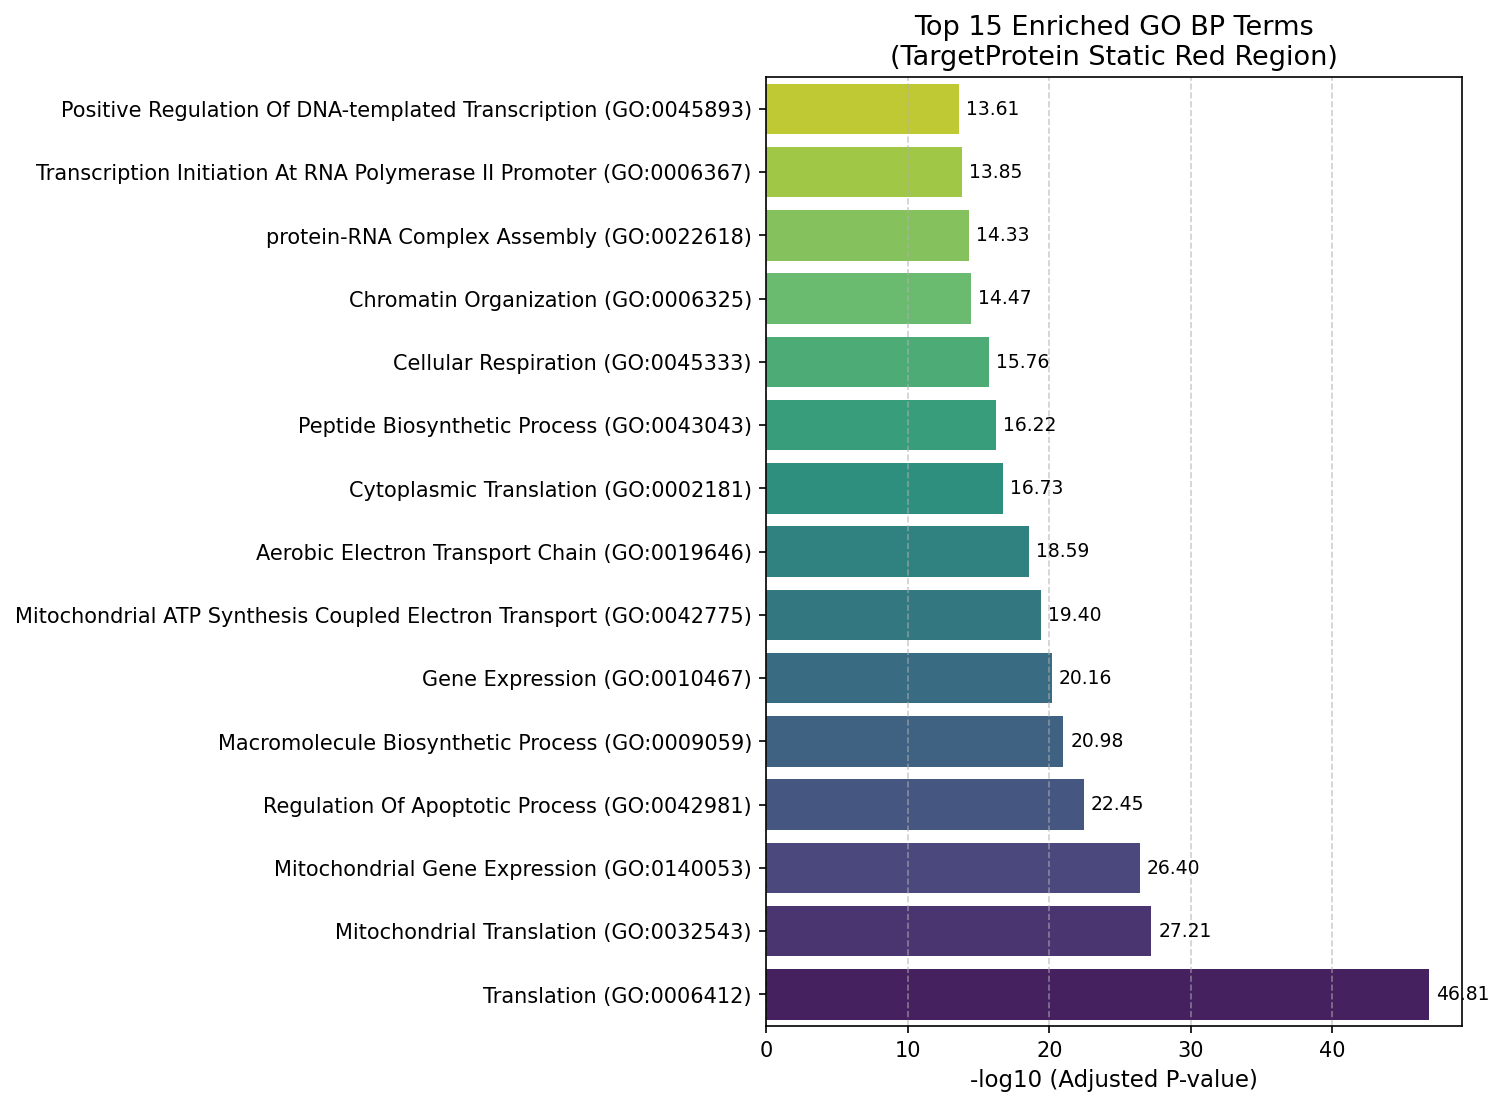


Cell 6: Plotting Enrichment Results (Static Red Region) complete.


In [6]:
# Cell 6: Plot Enrichment Results
# Description: Generates and displays a bar plot visualizing the top enriched GO terms
#              found in Cell 5 (Static Red Region). Saves the plot to the analysis output directory.
#              MODIFIED: Uses the updated create_enrichment_plot from Cell 2.

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import warnings
import traceback
from IPython.display import display, Image # For displaying saved images

print(f"\n--- Cell 6: Plotting Enrichment Results (Static Red Region) ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# --- Prerequisites Check ---
enrichment_plot_error = False
# Check for enrichment results DataFrame from Cell 5
if 'global_enrichment_results_analysis' not in globals() or not isinstance(global_enrichment_results_analysis, pd.DataFrame): print("❌ Skipping Plot: Enrichment results DataFrame missing or not a DataFrame (Run Cell 5)."); enrichment_plot_error = True
elif global_enrichment_results_analysis.empty: print("ℹ️ Skipping Plot: Enrichment results DataFrame is empty (No terms found in Cell 5)."); enrichment_plot_error = True
# Check if helper function is defined (Cell 2)
if 'create_enrichment_plot' not in globals() or not callable(create_enrichment_plot):
    print("❌ Skipping Plot: Helper function 'create_enrichment_plot' missing (Defined in Cell 2?)."); enrichment_plot_error = True
# Check for necessary config parameters (Cell 1 - accessed via GLOBALS by helper or passed)
if 'TOP_N_ENRICHMENT_TERMS' not in globals(): print("⚠️ TOP_N_ENRICHMENT_TERMS missing."); # Allow plot, use default in helper
if 'TARGET_NODE_NAME' not in globals(): print("⚠️ TARGET_NODE_NAME missing."); # Allow plot, use default in title
if 'OUTPUT_DIR_ANALYSIS' not in globals(): print("❌ Skipping Plot: Required global 'OUTPUT_DIR_ANALYSIS' missing (Run Cell 1)."); enrichment_plot_error = True
elif not os.path.isdir(OUTPUT_DIR_ANALYSIS): print(f"❌ Skipping Plot: Analysis output directory not found: {OUTPUT_DIR_ANALYSIS}. Check Cell 1."); enrichment_plot_error = True


# --- Execute Plotting ---
plot_filepath = None # Store path if saved
plot_success_cell6 = False
fig_handle_enrich = None # Store figure handle

if not enrichment_plot_error:
    try:
        # Use the enrichment results DataFrame from Cell 5
        results_df_to_plot = global_enrichment_results_analysis

        # Get parameters using defaults if globals are missing
        top_n_val = globals().get('TOP_N_ENRICHMENT_TERMS', 15)
        target_name = globals().get('TARGET_NODE_NAME', 'Target Protein')
        output_dir_analysis = globals().get('OUTPUT_DIR_ANALYSIS', '.')

        num_terms_available = len(results_df_to_plot.dropna(subset=['Adjusted P-value'])) # Count terms with valid p-value
        num_terms_to_plot_req = min(top_n_val, num_terms_available)

        # Construct plot title
        plot_title = f"Top {num_terms_to_plot_req} Enriched GO BP Terms\n({target_name} Static Red Region)" # Use target_name


        # Define plot output path
        plot_filename = os.path.join(output_dir_analysis, "red_region_enrichment_plot.png") # Consistent filename


        # Call the helper function defined in Cell 2
        # It now accesses top_n and output_dir from GLOBALS if not passed
        plot_success_call, fig_handle_enrich = create_enrichment_plot(
            results_df=results_df_to_plot,
            title=plot_title,
            output_filename=plot_filename # Pass the filename for saving
        )
        plot_success_cell6 = plot_success_call # Update success flag

    except Exception as e:
        print(f"❌ An error occurred during plot generation execution: {e}")
        traceback.print_exc()
    finally:
        # Ensure figure is closed after saving/failure
        if fig_handle_enrich is not None and plt.fignum_exists(fig_handle_enrich.number):
             plt.close(fig_handle_enrich)

    # Display Saved Plot inline (if generated and saved)
    if plot_success_cell6 and os.path.exists(plot_filename): # Check plot_success_cell6 flag
        print(f"\nDisplaying generated enrichment plot: {plot_filename}")
        try: display(Image(filename=plot_filename))
        except Exception as e_disp: print(f"  Could not display image inline: {e_disp}")
    elif not enrichment_plot_error:
        print("\n⚠️ Enrichment plot not generated/saved due to errors or no significant terms, cannot display inline.")

else: # enrichment_plot_error was True
    print("Skipping enrichment plot generation due to previous errors or no data.")


print("\nCell 6: Plotting Enrichment Results (Static Red Region) complete.")

In [7]:
# Cell 7: Biological Analysis Summary
# Description: Provides a brief markdown summary of the biological analysis results
#              for the STATIC Red Region, referencing the generated outputs.

import os
import numpy as np
import pandas as pd
import json # Keep json import
import time # Use time for timestamp

print(f"\n--- Cell 7: Biological Analysis Summary (Static Red Region) ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# --- Gather Info ---
# Get info from globals or locally defined variables in prior cells
run_analyzed = "N/A"; red_region_size = 0; genes_mapped_count = 0; enrichment_terms_count = 0; top_term_summary = "N/A"; top_pval_summary = np.nan
analysis_folder = "N/A"
analysis_successful = False # Flag indicates if enrichment found significant terms

# Get experiment name, if available in global config or inferred
exp_name_source = "H+P Reference Run (ablation_01)" # Explicitly state the source run for the static region file

# Get analysis output folder (should be set in Cell 1)
if 'OUTPUT_DIR_ANALYSIS' in globals(): analysis_folder = globals().get('OUTPUT_DIR_ANALYSIS')
# Get input file name (should be set in Cell 1)
red_region_ids_filename = os.path.basename(globals().get('RED_REGION_IDS_INPUT_FILE', 'aifm1_red_ids.txt')) # Get input filename base

# Get Red Region size (from Cell 3)
if 'red_region_string_ids' in globals() and isinstance(red_region_string_ids, list): red_region_size = len(red_region_string_ids)
# Get mapped genes count (from Cell 4)
if 'mapped_gene_symbols_analysis' in globals() and isinstance(mapped_gene_symbols_analysis, list): genes_mapped_count = len(mapped_gene_symbols_analysis)

# Get enrichment results info (from Cell 5)
if 'global_enrichment_results_analysis' in globals() and isinstance(global_enrichment_results_analysis, pd.DataFrame):
    if not global_enrichment_results_analysis.empty:
        # Enrichment successfully ran and found terms
        analysis_successful = True
        enrichment_terms_count = len(global_enrichment_results_analysis)
        try:
            # Access first row and columns safely
            if 'Term' in global_enrichment_results_analysis.columns: top_term_summary = global_enrichment_results_analysis.iloc[0]['Term']
            if 'Adjusted P-value' in global_enrichment_results_analysis.columns: top_pval_summary = global_enrichment_results_analysis.iloc[0]['Adjusted P-value']
            # top_term_summary string formatting handled below
        except Exception:
            # If error getting top term, still mark as successful but note error
            warnings.warn("Error getting top term info from enrichment results.")
            top_term_summary = "(Error extracting top term info)"

    else:
        # Enrichment ran but found no significant terms
        analysis_successful = False # Not "successful" in terms of finding sig terms
        enrichment_terms_count = 0
        top_term_summary = "No significant terms found"


# --- Print Markdown Summary ---
summary_text_lines = [f"## Biological Relevance Analysis: '{red_region_ids_filename}' (Static Red Region)", ""]
summary_text_lines.append(f"This analysis examines the biological relevance of the **static** 'Red Region' nodes identified at the final simulation step of the {exp_name_source}. These node IDs were loaded from the file `{red_region_ids_filename}`.")
summary_text_lines.append("")
summary_text_lines.append(f"- **Static Red Region Size (from `{red_region_ids_filename}`):** {red_region_size} nodes")
summary_text_lines.append(f"- **Mapped Gene Symbols:** {genes_mapped_count} unique symbols (via STRING API)")
summary_text_lines.append("")

# Add threshold used for Red Region definition (from Cell 1)
threshold_val_ref = globals().get('RED_REGION_THRESHOLD_USED_BY_01', 'N/A')
summary_text_lines.append(f"_(Note: The static Red Region in `{red_region_ids_filename}` was defined as nodes where Final Activation - Final Inhibition > {threshold_val_ref} in the {exp_name_source} run.)_")
summary_text_lines.append("")


summary_text_lines.append("### Functional Enrichment Analysis (GO Biological Process)")

if analysis_successful: # Enrichment found significant terms
     summary_text_lines.append(f"Significant enrichment was found for {enrichment_terms_count} GO Biological Process terms (Adjusted P-value < 0.05).")
     # Format top term summary string
     if pd.notna(top_pval_summary):
          top_term_display = f"**{top_term_summary}** (AdjP={top_pval_summary:.2e})"
     else:
          top_term_display = f"**{top_term_summary}** (AdjP=N/A)"
     summary_text_lines.append(f"The top enriched term is: {top_term_display}.")
     summary_text_lines.append("")
     summary_text_lines.append("The full enrichment results table is saved as `red_region_enrichment_results.csv`.")
     summary_text_lines.append("A bar plot visualizing the top terms is saved as `red_region_enrichment_plot.png`.")
     summary_text_lines.append("")
     summary_text_lines.append("Conclusion: The **static Red Region** from the H+P Reference simulation run is significantly enriched for specific biological processes, supporting the biological relevance of this definition of the emergent pattern.")

elif red_region_size > 0 and genes_mapped_count >= 3:
     # Enrichment ran, but found no significant terms
     summary_text_lines.append(f"A total of {genes_mapped_count} gene symbols were mapped from the {red_region_size} nodes in the Static Red Region.")
     summary_text_lines.append(f"However, no significant GO Biological Process terms were found with the current parameters (e.g., p < 0.05 threshold, library: '{globals().get('GO_ENRICHMENT_LIBRARY', 'N/A')}').")
     summary_text_lines.append("")
     summary_text_lines.append("Conclusion: While the Static Red Region contained a set of genes, functional enrichment analysis did not yield significant results under the chosen settings. This might suggest this specific static pattern is not strongly associated with a single GO BP process at this threshold, or requires different analysis parameters/libraries.")

elif red_region_size > 0:
     # Red region had nodes, but mapping yielded too few genes
     summary_text_lines.append(f"The Static Red Region contained {red_region_size} nodes.")
     summary_text_lines.append(f"Only {genes_mapped_count} unique gene symbols could be mapped from these nodes.")
     summary_text_lines.append("Functional enrichment analysis was skipped as fewer than 3 mapped genes were found.")
     summary_text_lines.append("")
     summary_text_lines.append("Conclusion: The Static Red Region size or mapping yield was insufficient to perform functional enrichment analysis.")

else: # Red region size is 0 (either file empty or load failed)
     summary_text_lines.append("No nodes were identified in the **static** 'Red Region' (file empty or missing).")
     summary_text_lines.append("Functional enrichment analysis was not possible for this static definition of the emergent pattern.")
     summary_text_lines.append("")
     summary_text_lines.append("Conclusion: The static 'Red Region' pattern was not found, so biological validation via enrichment could not be performed for this static definition.")

summary_text_lines.append("")
summary_text_lines.append(f"Analysis results (including CSVs and plot) are saved in the directory: `{os.path.relpath(analysis_folder) if analysis_folder!='N/A' else 'N/A'}`")

final_summary_text = "\n".join(summary_text_lines)

# --- Save Summary ---
# Get analysis folder path again reliably
analysis_folder_save = globals().get('OUTPUT_DIR_ANALYSIS', os.path.join(globals().get('ANALYSIS_DIR_BASE', 'biological_analysis_results'), 'Analysis_Unknown'))
summary_markdown_path = os.path.join(analysis_folder_save, "biological_analysis_summary_static_red_region.md") # Specific filename

try:
    with open(summary_markdown_path, 'w') as f:
        f.write(final_summary_text)
    print(f"\n✅ Static Red Region biological analysis summary saved to: {summary_markdown_path}")
except Exception as e:
    print(f"❌ Error saving biological analysis summary: {e}")

# --- Print Summary to Console ---
print("\n" + "="*80)
print(final_summary_text)
print("="*80)


print("\nCell 7: Biological Analysis Summary (Static Red Region) complete.")


--- Cell 7: Biological Analysis Summary (Static Red Region) (2025-04-28 21:16:59) ---

✅ Static Red Region biological analysis summary saved to: biological_analysis_results/Analysis_aifm1_red_ids/biological_analysis_summary_static_red_region.md

## Biological Relevance Analysis: 'aifm1_red_ids.txt' (Static Red Region)

This analysis examines the biological relevance of the **static** 'Red Region' nodes identified at the final simulation step of the H+P Reference Run (ablation_01). These node IDs were loaded from the file `aifm1_red_ids.txt`.

- **Static Red Region Size (from `aifm1_red_ids.txt`):** 707 nodes
- **Mapped Gene Symbols:** 707 unique symbols (via STRING API)

_(Note: The static Red Region in `aifm1_red_ids.txt` was defined as nodes where Final Activation - Final Inhibition > 0.5 in the H+P Reference Run (ablation_01) run.)_

### Functional Enrichment Analysis (GO Biological Process)
Significant enrichment was found for 3038 GO Biological Process terms (Adjusted P-value < 0